# Análise exploratória dos dados

Este notebook deve ser lido após o notebook `business_and_data_understanding`, ele se insere após termos resgatados os dados inicias a partir dos scripts de `src/data_collect`. Como conclusão da etapa de entendimento dos dados temos:

- Podemos usar a Pauta, o Requerimento e a Ementa que possuem informações textuais atreladas aos eventos legislativos.

Surgiu uma grande dificuldade na recuperação dos dados, temos que muitos dos links que direcionavam para as pautas resultavam em erros 403, tornando a quantia de dados das pautas bem abaixo do necessário para termos significância e utilizar isso em um contexto real. Iremos começar a analisá-las e posteriormente verificarmos se queremos prosseguir utilizando-as.

Como não colocamos uma forma de retry nas requisições é possível que muitas pautas não tenham sido obtidas por uma instabilidade nos links e na rede da câmara.

Os dados obtidos foram da semana 13/07/2025 a 19/07/2025.

Neste notebook também será pensando em como iremos portar as informações textuais para serem usadas na recuperação.

Vamos ler os arquivos CSV contendo os dados que obtivemos com os scritps.

In [1]:
# !pip install matplotlib
# !pip install seaborn
# !pip install wordcloud
# !pip install spacy
# !pip install transformers
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install umap-learn
# !pip install numpy==2.2.0
# !pip install datasets
# !pip install scikit-learn
# !pip install umap-learn

In [1]:
import ast
import torch
import spacy
import pandas as pd
from umap import UMAP
import seaborn as sns

from datasets import Dataset
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

from sklearn.preprocessing import MinMaxScaler

from wordcloud import WordCloud

c:\Users\renne\anaconda3\envs\tcc-pos\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# !python -m spacy download pt_core_news_sm

Configurações iniciais para funcionalidade do Notebook

In [2]:
nlp = spacy.load("pt_core_news_sm")

In [3]:
%cd ..

c:\Users\renne\Documents\repos\legislativo-nlp


Vamos carregar os Dataframes com as informações coletadas

In [4]:
events_with_topics = pd.read_csv("data/datasets/raw/events_with_topics.csv", encoding="utf-8-sig")
motions = pd.read_csv("data/datasets/raw/motions.csv", encoding="utf-8-sig")

In [5]:
events_with_topics.head()

,id,uri,dataHoraInicio,dataHoraFim,situacao,descricaoTipo,descricao,localExterno,orgaos,localCamara,urlRegistro,details,topics
0,75866,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-15T09:00,NaN,Agendada,Sessão Não Deliberativa Solene,Homenagem ao Dia do Esporte\r\n Homenagem ao D...,NaN,"[{'id': 180, 'uri': 'https://dadosabertos.cama...","{'nome': 'Plenário da Câmara dos Deputados', '...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN
1,76380,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-18T19:00,NaN,Convocada,Simpósio,Abertura da 19ª edição do projeto Politea\r\n ...,NaN,"[{'id': 100950, 'uri': 'https://dadosabertos.c...","{'nome': 'Auditório Nereu Ramos', 'predio': No...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN
2,76582,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-15T14:00,NaN,Convocada,Audiência Pública,Sustentabilidade na Produção e Comercialização...,NaN,"[{'id': 2004, 'uri': 'https://dadosabertos.cam...","{'nome': 'Anexo II, Plenário 08', 'predio': No...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN
3,76801,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-17T16:00,NaN,Convocada,Seminário,Aspectos legais e ambientais relativos à impla...,Câmara Municipal de Saquarema,"[{'id': 6174, 'uri': 'https://dadosabertos.cam...","{'nome': None, 'predio': None, 'sala': None, '...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN
4,76873,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-16T14:30,NaN,Convocada,Audiência Pública,"Projeto de Lei nº 761/2025, de autoria do Depu...",NaN,"[{'id': 2001, 'uri': 'https://dadosabertos.cam...","{'nome': 'A Definir', 'predio': None, 'sala': ...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN


Vemos que os arquivos foram salvos corretamente, apenas temos a transformações dos None originais para NaN.

In [6]:
events_with_topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              60 non-null     int64  
 1   uri             60 non-null     object 
 2   dataHoraInicio  60 non-null     object 
 3   dataHoraFim     0 non-null      float64
 4   situacao        60 non-null     object 
 5   descricaoTipo   60 non-null     object 
 6   descricao       60 non-null     object 
 7   localExterno    12 non-null     object 
 8   orgaos          60 non-null     object 
 9   localCamara     60 non-null     object 
 10  urlRegistro     0 non-null      float64
 11  details         60 non-null     object 
 12  topics          13 non-null     object 
dtypes: float64(2), int64(1), object(10)
memory usage: 6.2+ KB


In [8]:
events_with_topics.describe(include="object")

,uri,dataHoraInicio,situacao,descricaoTipo,descricao,localExterno,orgaos,localCamara,details,topics
count,60,60,60,60,60,12,60,60,60,13
unique,60,29,3,12,52,11,36,18,60,13
top,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-16T10:00,Convocada,Audiência Pública,Discussão e votação de propostas legislativas,"Anexo II, Pav. Superior, Ala C, sala 176","[{'id': 180, 'uri': 'https://dadosabertos.cama...","{'nome': None, 'predio': None, 'sala': None, '...","{'uriDeputados': None, 'uriConvidados': None, ...",Pauta - CEXCIRS - 14/07/2025 10:00\nCÂMARA DOS...
freq,1,7,55,20,9,2,5,12,1,1


## Análise Quantitativa e Tratamento dos Dados

Iremos navegar sob os dados recuperados para podermos ver se há informações a serem retiradas e como elas se relacionam com os dados textuais presentes. Durante este processo também serão realizadas diversas etapas de tratamento dos dados, como o processo de feature engineering e limpeza.

### Análise dos Eventos

In [9]:
print(f"Eventos com pauta {events_with_topics.shape[0] - events_with_topics.topics.isnull().sum()}")

Eventos com pauta 13


Temos que apenas 13 pautas foram resgatadas, o que é menos que um quarto dos eventos, como comentado previamente, podem ter ocorrido problemas na conexão com a página ou elas não estão disponíveis.

In [10]:
events_with_topics.descricaoTipo.value_counts()

descricaoTipo
Audiência Pública                  20
Reunião Deliberativa               20
Mesa Redonda                        4
Seminário                           3
Reunião Técnica                     3
Sessão Não Deliberativa Solene      2
Audiência Pública e Deliberação     2
Comissão Geral                      2
Simpósio                            1
Visita Técnica                      1
Reunião de Eleição                  1
Sessão Deliberativa                 1
Name: count, dtype: int64

Para a próxima semana o evento de maior predominância é de Audiência Pública, seguido de Reuniões deliberativas.

In [11]:
events_with_topics.situacao.value_counts()

situacao
Convocada    55
Agendada      4
Cancelada     1
Name: count, dtype: int64

Conseguimos visualizar também os 3 tipos de situação, onde a maioria (55) está convocada, 4 agendadas e apenas 1 cancelada.

Para visualizarmos os órgãos que os eventos se referem precisamos tratar essa coluna e retirá-la do JSON original. Vamos considerar inicialmente que um evento pode possuir apenas uma comissão. Vamos utilziar essa informação de comissão como um guia de tema, para conseguirmos clusterizar os dados textuais baseando-se no que teriamos mais aproximadas de uma "ground truth" do tema proposto.

In [12]:
events_with_topics.orgaos.iloc[0]

"[{'id': 180, 'uri': 'https://dadosabertos.camara.leg.br/api/v2/orgaos/180', 'sigla': 'PLEN', 'nome': 'Plenário', 'apelido': 'Plenário', 'codTipoOrgao': 26, 'tipoOrgao': 'Plenário Virtual', 'nomePublicacao': 'Plenário', 'nomeResumido': 'Plenário'}]"

Temos aqui o primeiro processo de feature engineering a ser aplicado aos dados, a extração das comissões.

In [13]:
def extract_comission(orgao):
    try:
        orgaos = ast.literal_eval(orgao)  # Converte string para lista de dicts

        first_comission = orgaos[0].get("nome")
        return first_comission
    except Exception as e:
        print(f"Erro ao processar: {e}")
        return None

# Aplicar no DataFrame
events_with_topics["comission"] = events_with_topics["orgaos"].apply(extract_comission)

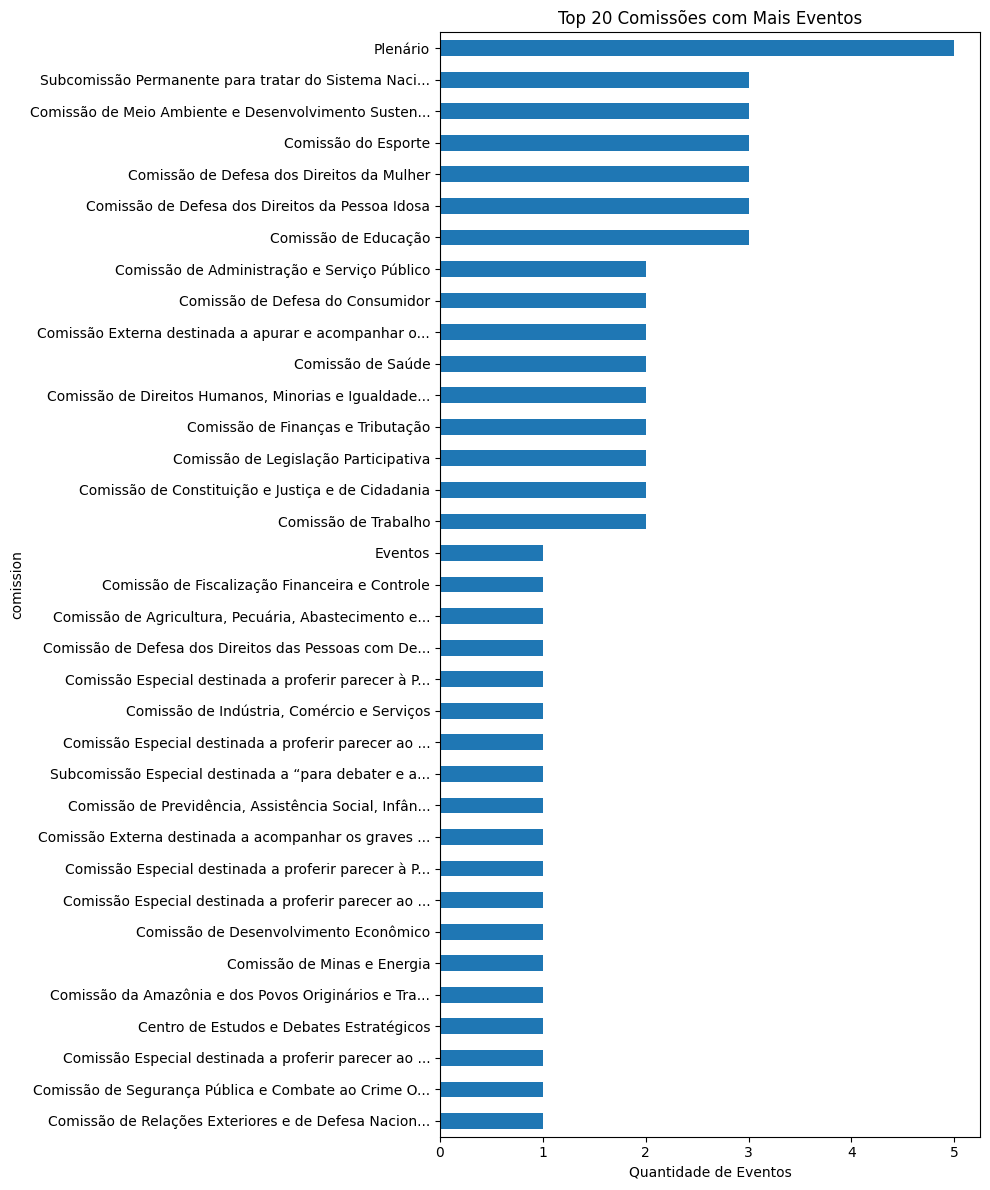

In [14]:
contagem_comissoes = events_with_topics["comission"].value_counts()

plt.figure(figsize=(10, 12))
ax = contagem_comissoes.plot(kind="barh")
plt.title("Top 20 Comissões com Mais Eventos")
plt.xlabel("Quantidade de Eventos")
plt.gca().invert_yaxis()
max_len = 50
yticklabels = [
    label.get_text()[:max_len] + "..." if len(label.get_text()) > max_len else label.get_text()
    for label in ax.get_yticklabels()
]
ax.set_yticklabels(yticklabels)

plt.tight_layout()
plt.show()

Temos a maioria dos eventos, são eventos de Plenários seguido por comissões diversas contendo 3 eventos, conseguimos perceber que a quantia de eventos é muito homogênea entre as comissões.

Partindo para uma análise do texto. Vamos analisar os tamanhos das descrições e pautas. Para isso precisamos criar colunas de tamanho.

Text(0.5, 1.0, 'Distribuição do Tamanho das descrições dos Eventos')

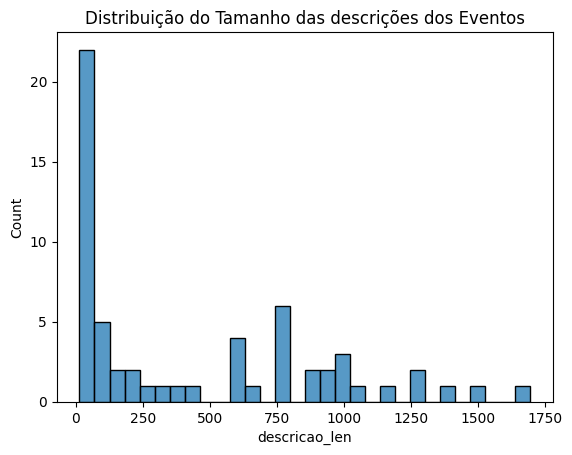

In [15]:
events_with_topics["descricao_len"] = events_with_topics["descricao"].str.len()
not_null_description_len = events_with_topics["descricao_len"].dropna()

sns.histplot(not_null_description_len, bins=30)
plt.title("Distribuição do Tamanho das descrições dos Eventos")

Text(0.5, 1.0, 'Distribuição do Tamanho das Pautas dos Eventos')

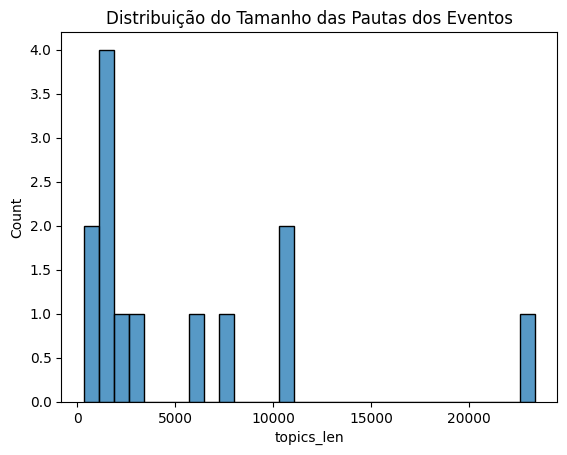

In [16]:
events_with_topics["topics_len"] = events_with_topics["topics"].str.len()
not_null_topics_len = events_with_topics["topics_len"].dropna()


sns.histplot(not_null_topics_len, bins=30)
plt.title("Distribuição do Tamanho das Pautas dos Eventos")

Temos uma grande concentração de eventos com Descrições e Pautas bem pequenas, sendo uma curva com uma grande cauda para a direita, em que há poucos com descrições muito grandes.


---

### Análise dos requerimentos

Vamos partir agora para a análise dos dados de requerimentos. Como comentado anteriormente, criamos um DataFrame próprio para os requerimentos devido a relação 1:N entre Requerimentos e Eventos, eles apresentam em primeiro instante muito mais informações textuais necessárias para o nosso objetivo. Onde para os 60 eventos resgatados conseguimos resgatar 59 requerimentos.

In [17]:
motions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   titulo    59 non-null     object
 1   uri       59 non-null     object
 2   event_id  59 non-null     int64 
 3   details   59 non-null     object
 4   status    59 non-null     object
 5   ementa    59 non-null     object
 6   pdf_url   59 non-null     object
 7   id        59 non-null     object
 8   pdf_text  59 non-null     object
dtypes: int64(1), object(8)
memory usage: 4.3+ KB


Todos os requerimentos apresentam campos não nulos, ou seja foi possível resgatar informações inclusive do PDF de todos.

In [18]:
motions.tail()

,titulo,uri,event_id,details,status,ementa,pdf_url,id,pdf_text
54,REQ 55/2025 CASP,https://dadosabertos.camara.leg.br/api/v2/prop...,77302,"{'id': 2529118, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer que seja autorizada pela Comissão de Ad...,https://www.camara.leg.br/proposicoesWeb/prop_...,55_2025,.\n\nP\nS\nA\nC\n-\n7\n7\n5\n0\n1\n:\n5\n1\n:\...
55,REQ 56/2025 CASP,https://dadosabertos.camara.leg.br/api/v2/prop...,77302,"{'id': 2529119, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer que seja autorizada pela Comissão de Ad...,https://www.camara.leg.br/proposicoesWeb/prop_...,56_2025,.\n\nP\nS\nA\nC\n-\n0\n6\n0\n1\n3\n:\n5\n2\n:\...
56,REQ 97/2025 CESPO,https://dadosabertos.camara.leg.br/api/v2/prop...,77312,"{'id': 2532661, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer a realização de audiência pública com o...,https://www.camara.leg.br/proposicoesWeb/prop_...,97_2025,COMISSÃO DO ESPORTE \n\nREQUERIMENTO Nº ...
57,REQ 48/2025 CLP,https://dadosabertos.camara.leg.br/api/v2/prop...,77314,"{'id': 2516920, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer a realização de Audiência Pública para ...,https://www.camara.leg.br/proposicoesWeb/prop_...,48_2025,CÂMARA DOS DEPUTADOS\nGabinete Deputado João D...
58,REQ 97/2025 CESPO,https://dadosabertos.camara.leg.br/api/v2/prop...,77315,"{'id': 2532661, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer a realização de audiência pública com o...,https://www.camara.leg.br/proposicoesWeb/prop_...,97_2025,COMISSÃO DO ESPORTE \n\nREQUERIMENTO Nº ...


Vamos verificar se não há duplicatas

In [19]:
motions.duplicated(subset=["id"]).sum()

np.int64(11)

Aqui enfretamos uma dificuldade no que tange a representação dos dados. Temos requerimentos com duplicatas nos IDs! Isso levanta uma necessidade de análise de são requerimentos iguais ou não, foi identificado que requerimentos podem ter IDs iguais porém textos diferentes de acordo com suas comissões. Isso torna uma necessidade de resgatarmos os dados novamente pois os pdfs foram salvos com base inicialmente no ID. Criamos então uma nova coluna, referente ao ID do Requerimento, juntando com a sigla da comissão.

In [20]:
motions[motions["id"] == '1_2025']

,titulo,uri,event_id,details,status,ementa,pdf_url,id,pdf_text
22,REQ 1/2025 CEXRSFEM,https://dadosabertos.camara.leg.br/api/v2/prop...,77154,"{'id': 2520689, 'uri': 'https://dadosabertos.c...",Aguardando Deliberação,"Requer a realização de 2 (dois) Seminários, a ...",https://www.camara.leg.br/proposicoesWeb/prop_...,1_2025,CÂMARA DOS DEPUTADOS\n\nCOMISSÃO EXTERNA SOBRE...
25,REQ 1/2025 PL233823,https://dadosabertos.camara.leg.br/api/v2/prop...,77186,"{'id': 2514511, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer a realização de audiência pública para ...,https://www.camara.leg.br/proposicoesWeb/prop_...,1_2025,COMISSÃO ESPECIAL SOBRE INTELIGÊNCIA ARTIFICIA...


Text(0.5, 1.0, 'Distribuição do Tamanho dos títulos dos Requerimentos')

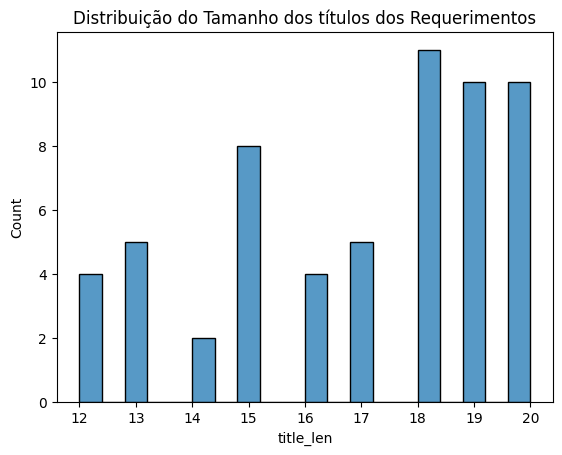

In [21]:
motions["title_len"] = motions["titulo"].str.len()
sns.histplot(motions["title_len"], bins=20)
plt.title("Distribuição do Tamanho dos títulos dos Requerimentos")

Temos que os títulos são realmente curtos e variam de  12 a 20 caracteres.

Temos nas ementas dos requerimentos um sumário do que ele se refere.

In [22]:
motions["ementa"].str.len().describe()
motions["ementa"].sample(5)

33    Requer a realização de audiência pública na Co...
21    Requer a realização de Mesa Redonda no Estado ...
49    Requer que seja convidada a Exma. Sra. Macaé E...
45    Requer a realização de audiência pública para ...
31    Requer a realização de quatro audiências públi...
Name: ementa, dtype: object

Text(0.5, 1.0, 'Distribuição do Tamanho da Ementa')

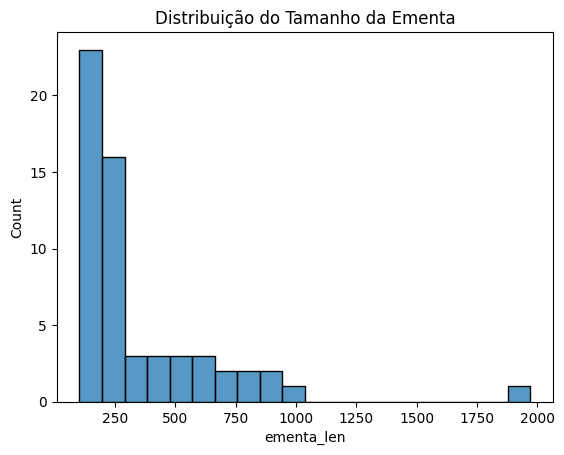

In [23]:
motions["ementa_len"] = motions["ementa"].str.len()
sns.histplot(motions["ementa_len"], bins=20)
plt.title("Distribuição do Tamanho da Ementa")

Verificamos que a maioria das ementas se encontra entre 100 e 300 caracteres, com predominância para 16 ementas com aproximados 250 caracteres.

Há uma ementa que pode ser vista como um Outlier de quase 2000 caracteres.

Text(0.5, 1.0, 'Distribuição do Tamanho do Requerimento em PDF')

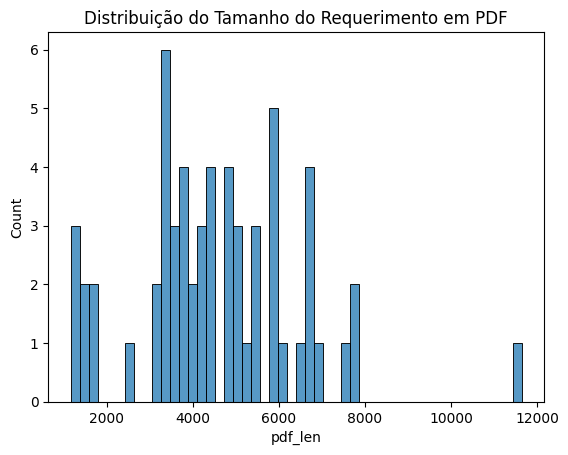

In [24]:
motions["pdf_len"] = motions["pdf_text"].str.len()
sns.histplot(motions["pdf_len"], bins=50)
plt.title("Distribuição do Tamanho do Requerimento em PDF")

Já para o tamanho do PDF temos diversos tamanhos sendo um gráfico bastante homogênio para a quantia de Bins utilizada.

In [25]:
motions["event_id"].value_counts().head()

event_id
77186    15
76955     5
77221     4
77224     3
77195     2
Name: count, dtype: int64

Temos para o evento de id 77186 a presença de 15 requerimentos! Mais que o triplo do que o segundo colocado com mais quantias.

<Axes: title={'center': 'Situação dos Requerimentos'}, ylabel='status'>

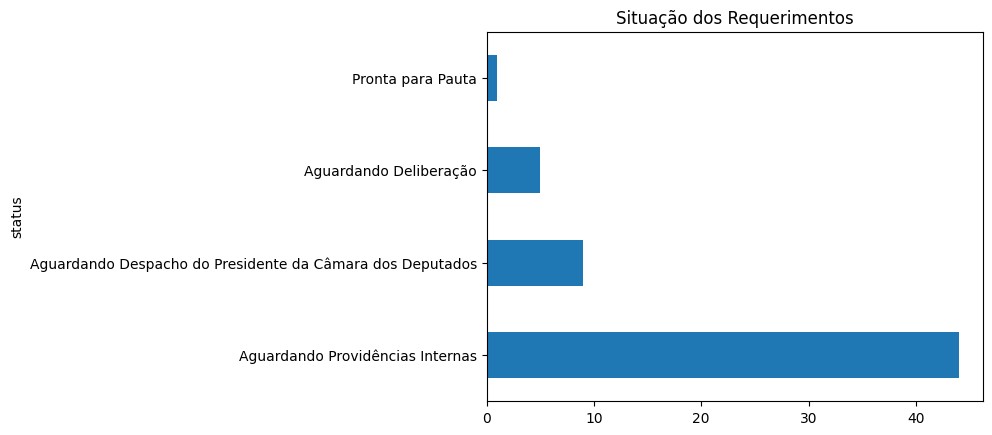

In [27]:
motions["status"].value_counts().plot(kind="barh", title="Situação dos Requerimentos")

Temos uma grande predominância do Status "Aguardando Providências Internas"

Temos que em termos proporcionais os Requerimentos apresentam tamanhos maiores que as Pautas resgatadas, além disso as ementas também podem servir de auxílio para o processo de recuperação, possuindo tamanhos de texto consideráveis.


## Análise com técnicas de NLP

Vamos partir agora para uma análise focada em ténicas de NLP, para isso devemos tratar nossos dados textuais, e utilziar de técnicas como BoW e NER. Esta etapa é crucial para conseguirmos identificar como limpar nossos dados e como eles estão sendo apresentados em uma estrutura semântica.

Para eventos vamos focar em duas colunas de interesse: descricao e topics (Pauta)


In [28]:
cleaned_events = events_with_topics.copy()

In [29]:
cleaned_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              60 non-null     int64  
 1   uri             60 non-null     object 
 2   dataHoraInicio  60 non-null     object 
 3   dataHoraFim     0 non-null      float64
 4   situacao        60 non-null     object 
 5   descricaoTipo   60 non-null     object 
 6   descricao       60 non-null     object 
 7   localExterno    12 non-null     object 
 8   orgaos          60 non-null     object 
 9   localCamara     60 non-null     object 
 10  urlRegistro     0 non-null      float64
 11  details         60 non-null     object 
 12  topics          13 non-null     object 
 13  comission       60 non-null     object 
 14  descricao_len   60 non-null     int64  
 15  topics_len      13 non-null     float64
dtypes: float64(3), int64(2), object(11)
memory usage: 7.6+ KB


Inicialmente vamos pré-processar o texto realizando:

- A tokenização por palavras.
- Repassagem para minúsculo.
- Lematização do texto
- Remoção de stop words
- Retirada de textos nulos
- Verificação de alfanuméricos.

In [30]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)

# Aplicar em coluna de descrição (exemplo)
cleaned_events["descricao"] = cleaned_events["descricao"].fillna("").apply(preprocess_text)
cleaned_events["topics"] = cleaned_events["topics"].fillna("").apply(preprocess_text)


In [31]:
cleaned_events["descricao"].iloc[0]

'homenagem dia esporte homenagem dia esporte'

In [32]:
cleaned_events["num_words"] = cleaned_events["descricao"].apply(lambda x: len(x.split()))
cleaned_events["num_chars"] = cleaned_events["descricao"].apply(len)

print("Resumo das quantidades de palavras na descrição:")
print(cleaned_events["num_words"].describe())


Resumo das quantidades de palavras na descrição:
count     60.000000
mean      39.416667
std       40.600280
min        1.000000
25%        5.000000
50%       18.000000
75%       70.250000
max      145.000000
Name: num_words, dtype: float64


Top 20 palavras mais frequentes nas decrições:
[('confirmar', 96), ('nacional', 48), ('representante', 32), ('deputado', 28), ('público', 28), ('requerimento', 27), ('presidente', 26), ('discussão', 25), ('legislativo', 24), ('votação', 21), ('nº', 20), ('req', 20), ('trabalho', 18), ('saúde', 17), ('proposta', 17), ('Associação', 15), ('autoria', 15), ('união', 15), ('comissão', 14), ('brasileiro', 14)]


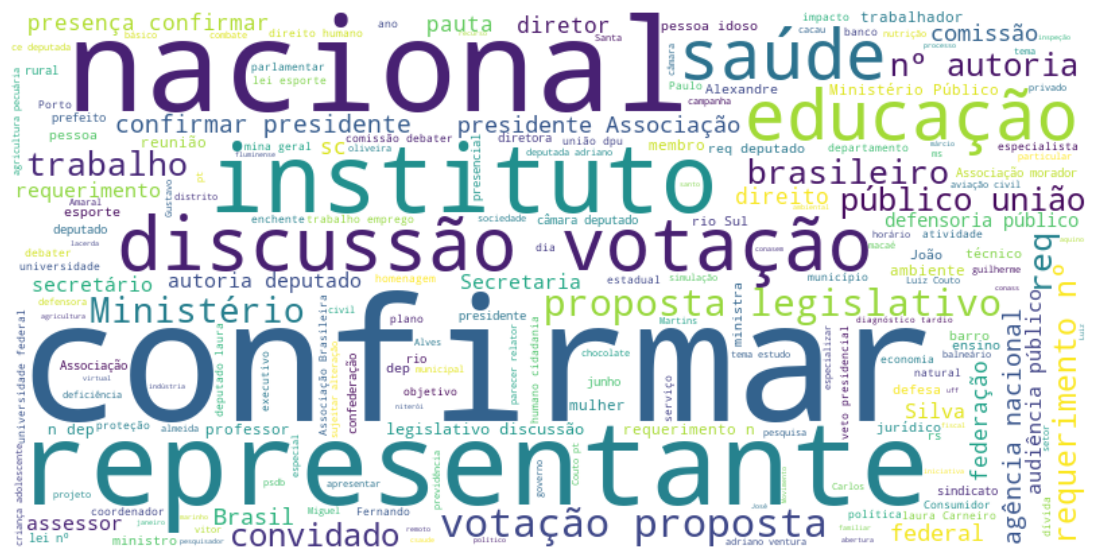

In [33]:
description = " ".join(cleaned_events["descricao"])

word_counts_descriptions = Counter(description.split())
print("Top 20 palavras mais frequentes nas decrições:")
print(word_counts_descriptions.most_common(20))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(description)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Top 20 palavras mais frequentes nas pautas:
[('nº', 217), ('lei', 155), ('deputado', 151), ('projeto', 128), ('pl', 126), ('parecer', 112), ('relator', 108), ('comissão', 76), ('aprovação', 75), ('legislativo', 74), ('substitutivo', 57), ('pauta', 56), ('apensar', 55), ('alterar', 53), ('público', 47), ('serviço', 44), ('nacional', 41), ('requerimento', 38), ('emenda', 38), ('relatora', 33)]


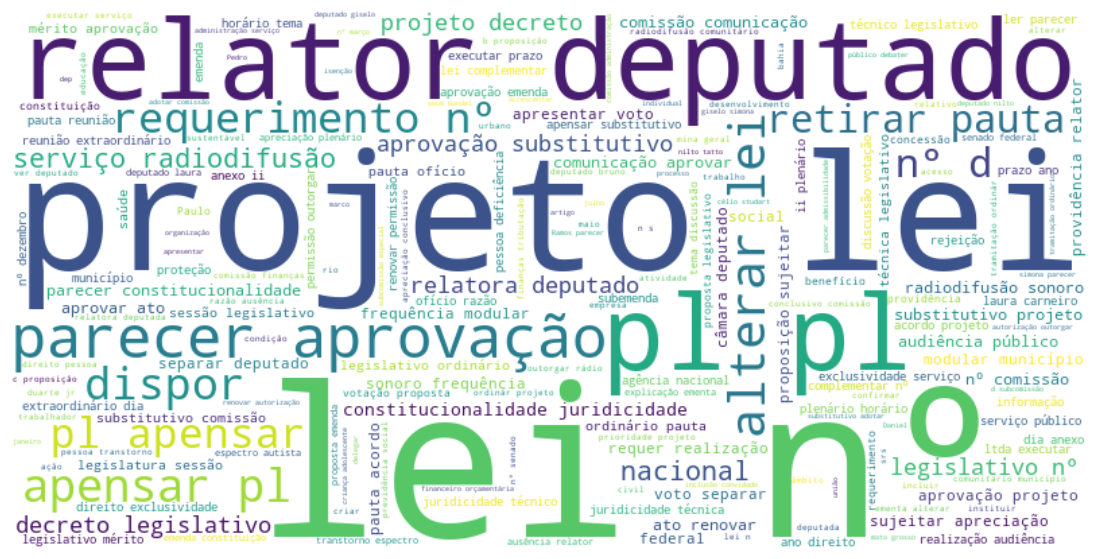

In [34]:
topics = " ".join(cleaned_events["topics"])

topics_word_counts = Counter(topics.split())
print("Top 20 palavras mais frequentes nas pautas:")
print(topics_word_counts.most_common(20))

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topics)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Essas nuvens de palavras nos fornecem um insight necessário para o processamento dos textos que iremos manipular: A enorme quantidade de jargões e palavras técnicas. Neste presente notebook por se tratar de um processo experimental e iterativo iremos pegar tal nuvem de palavras e utilizá-la para remoção de tais jargões/ruídos em nosso código modular. 

Manter estas palavras podem tornar nossas informações textuais "idênticas" não sendo possível retornar os assuntos de interesse. 

Vamos identificar as entidades nomeadas que os textos possuem.

In [ ]:
def extract_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

cleaned_events["entities"] = cleaned_events["descricao"].fillna("").apply(extract_ner)

In [ ]:
ent_type_counter = Counter()
ent_text_by_type = defaultdict(list)

for ents in cleaned_events["entities"]:
    for text, label in ents:
        ent_type_counter[label] += 1
        ent_text_by_type[label].append(text)

In [37]:
print("Tipos de entidade mais frequentes nas descrições:")
for ent_type, count in ent_type_counter.most_common():
    print(f"{ent_type}: {count} ocorrências")

print("\nExemplos de entidades por tipo:")
for ent_type, texts in ent_text_by_type.items():
    exemplos = list(set(texts))[:5]  
    print(f"{ent_type}: {exemplos}")

Tipos de entidade mais frequentes nas descrições:
PER: 118 ocorrências
LOC: 68 ocorrências
ORG: 19 ocorrências
MISC: 9 ocorrências

Exemplos de entidades por tipo:
LOC: ['Secretaria', 'Rio', 'Educação', 'universidade brasília', 'universidade federal goiás ricardo paesr']
PER: ['Martins', 'Movimento Porto', 'Carlos', 'Maria', 'wagner lenhart']
ORG: ['Ministério Público Rio', 'Educação', 'Nacional', 'direteor', 'Nacional educação']
MISC: ['Am nº', 'nºs', 'sc alexsandro', 'comissão debater semana', 'Secretaria nacional Consumidor senacon']


O tipo de entidade nomeada mais frequente é de Person (pessoas), seguido de localização.
Temos uma grande coletânea de diversos tipos de NER.

Fazendo o mesmo para as pautas temos:

In [38]:
cleaned_events["entities_topics"] = cleaned_events["topics"].fillna("").apply(extract_ner)

In [39]:
ent_type_counter = Counter()
ent_text_by_type = defaultdict(list)

for ents in cleaned_events["entities_topics"]:
    for text, label in ents:
        ent_type_counter[label] += 1
        ent_text_by_type[label].append(text)

print("Tipos de entidade mais frequentes nas pautas:")
for ent_type, count in ent_type_counter.most_common():
    print(f"{ent_type}: {count} ocorrências")

print("\nExemplos de entidades por tipo:")
for ent_type, texts in ent_text_by_type.items():
    exemplos = list(set(texts))[:5]  
    print(f"{ent_type}: {exemplos}")


Tipos de entidade mais frequentes nas pautas:
PER: 167 ocorrências
LOC: 56 ocorrências
MISC: 18 ocorrências
ORG: 4 ocorrências

Exemplos de entidades por tipo:
LOC: ['universidade federal goiás', 'Secretaria', 'Educação', 'Santa catarino', 'Faria']
ORG: ['cpd', 'assembleia legislativo mina geral', 'Kicis']
PER: ['julio cesar', 'benefício creditício', 'Sidney Leite', 'Martins', 'Pedro Campos']
MISC: ['Renata', 'Lei nº amom mandel alterar lei nº maio ampliar conceito', 'nºs', 'Franca', 'sâmio bomfim']


Mantemos a predominância de pessoas seguido de localizações.

### Análise Semântica

Para realizar uma análise semântica dos textos vamos aplicar os dois campos de interesse para uma abordagem de embeddings, utilizando o BERTimbau, com isso iremos verificar como os textos se distanciam no espaço vetorial para as diferentes comissões, como comentado anteriormente estas são as que mais nos aproximam de uma ground truth temática em momento inicial. Devido ao maior tamanho vamos aplicar isto apenas as Pautas.

Cabe ressaltar pelos insights obtidos da Nuvem de Palavras, que as análises semânticas aqui dispostas conterão os textos ruidosos dos jargões técnicos.

In [40]:
from transformers import (
    AutoModel,
    AutoTokenizer,
)

In [41]:
model_ckpt = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) # Resgata tokenizador distilbert

In [48]:
def tokenize(batch):
  # Garantia que os dados de texto serão strings
  texts = [str(text) for text in batch["topics"]]

  # Caso acima de 512, trunca-se os dados
  # Para o caso de saúde não teremos esse comportamento
  encodings = tokenizer(texts, padding=True, truncation=True, max_length=512)

  # Preserva a coluna label de saída no map
  encodings["comission"] = batch["comission"]

  return encodings

In [49]:
topics_embedding = cleaned_events[["topics", "comission"]].dropna()
topics_embedding = topics_embedding[topics_embedding["topics"] != ""].reset_index(drop=True)

In [50]:
topics_embedding_dataset = Dataset.from_pandas(topics_embedding)

In [51]:
topics_text_encoded = topics_embedding_dataset.map(
    tokenize,
    batched=True, # Garante o processamento em batch
    batch_size=None # Define um valor dinâmico ao batch
)

Map: 100%|██████████| 13/13 [00:00<00:00, 260.28 examples/s]


Vamos usar agora o BERTimbau como extrator de "features" a partir dos embeddings.

Os embeddings podem ser vistos como a representação inicial de uma palavra ou unidade de texto (seja ela estática ou contextuais).

Já os hidden states são as representações intermediárias mais complexas que o modelo constrói camada por camada, vamos extrair o hidden state dos embedding para o token [CLS], este por padrão contém informação de toda a sequência de texto. Retirando a informação do Hidden state conseguimos obter um embedding muito mais rico com informação semântica devido a passagem pela rede neural do modelo.

Por estarmos lidando com poucos dados, não vai ser essencial o uso de uma GPU.

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [53]:
def extract_hidden_states(batch):

    # Repassa entradas do modelo para a GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad(): # Congela o modelo BERT, ou seja não calcula gradiente
        last_hidden_state = model(**inputs).last_hidden_state

    # Retornamos os valore da camada oculta para a CPU como um array Numpy
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

topics_text_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "comission"]
) # Transforma os tokens em Tensors utilizando PyTorch

# Mapeia os Tensors com Tokens para o modelo, resgatando os valores da camada oculta
topics_hidden_features = topics_text_encoded.map(
    extract_hidden_states,
    batched=True
)

Map: 100%|██████████| 13/13 [00:06<00:00,  2.04 examples/s]


In [54]:
topics_hidden_features.column_names

['topics',
 'comission',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden_state']

In [55]:
topics_hidden_features

Dataset({
    features: ['topics', 'comission', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
    num_rows: 13
})

In [57]:
y_topics = topics_hidden_features["comission"]
X_topics = topics_hidden_features.remove_columns(["topics", "comission"])

In [58]:
X_topics_scaled = MinMaxScaler().fit_transform(X_topics["hidden_state"])

mapper = UMAP(n_components=2, metric="cosine").fit(X_topics_scaled)

df_embedding = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_topics
df_embedding.head()

c:\Users\renne\anaconda3\envs\tcc-pos\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\renne\anaconda3\envs\tcc-pos\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


,X,Y,label
0,5.614372,-12.482850,Comissão Externa destinada a apurar e acompanh...
1,6.308644,-13.831260,"Comissão de Indústria, Comércio e Serviços"
2,6.470880,-13.057549,Comissão Especial destinada a proferir parecer...
3,7.807099,-11.765063,Comissão de Defesa dos Direitos das Pessoas co...
4,7.011218,-11.400791,Comissão de Minas e Energia


In [59]:
df_embedding

,X,Y,label
0,5.614372,-12.482850,Comissão Externa destinada a apurar e acompanh...
1,6.308644,-13.831260,"Comissão de Indústria, Comércio e Serviços"
2,6.470880,-13.057549,Comissão Especial destinada a proferir parecer...
3,7.807099,-11.765063,Comissão de Defesa dos Direitos das Pessoas co...
4,7.011218,-11.400791,Comissão de Minas e Energia
5,8.163145,-12.283000,Comissão de Administração e Serviço Público
6,7.043325,-13.592836,Comissão de Desenvolvimento Econômico
7,7.761706,-13.439162,Comissão de Meio Ambiente e Desenvolvimento Su...
8,7.522512,-12.778416,Comissão de Finanças e Tributação
9,8.373257,-12.991375,Comissão de Constituição e Justiça e de Cidadania


C:\Users\renne\AppData\Local\Temp\ipykernel_32104\1359967360.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


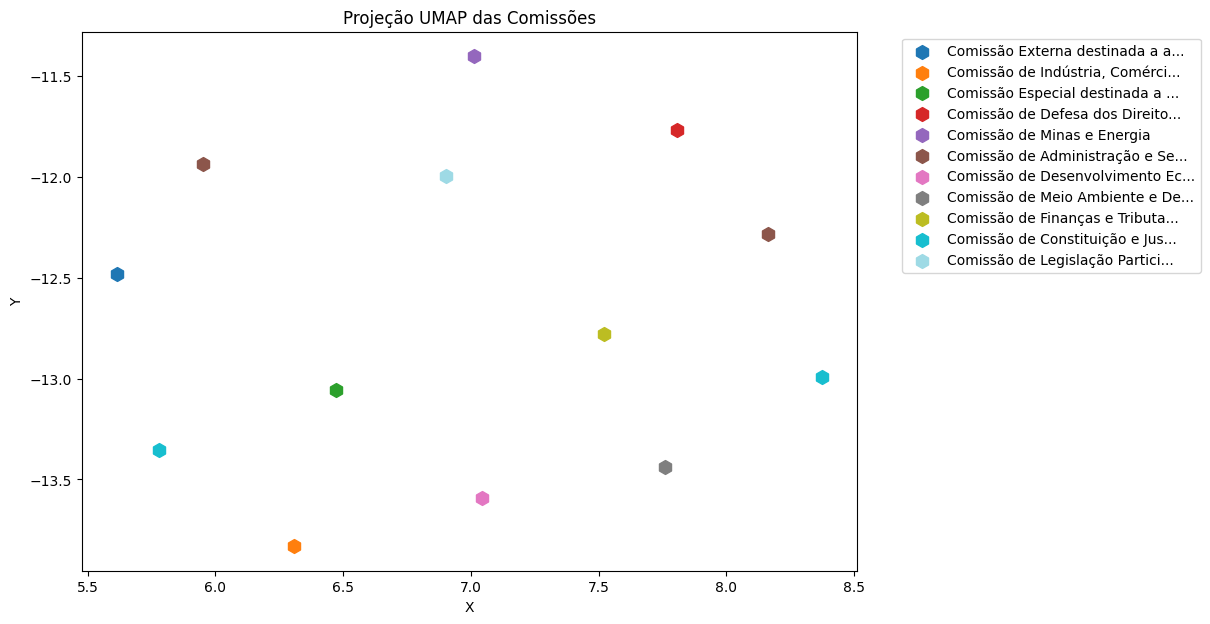

In [60]:
labels_trunc = df_embedding["label"].apply(lambda x: x[:30] + "..." if len(x) > 30 else x)

plt.figure(figsize=(10,7))

unique_labels = labels_trunc.unique()
colors = plt.cm.get_cmap('tab20', len(unique_labels))

for i, label in enumerate(unique_labels):
    idx = labels_trunc == label
    plt.scatter(
        df_embedding.loc[idx, "X"], 
        df_embedding.loc[idx, "Y"], 
        label=label, 
        marker='h',  # hexágono
        s=100,       # tamanho do marcador
        color=colors(i)
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Projeção UMAP das Comissões")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


Como temos pouca quantia de eventos temos um gráfico muito espaçado entre os pontos! Porém percebemos registros da Comissão de Constituição muito distantes entre si.

Devemos agora fazer os mesmos procedimentos para os Requerimentos! O Objetivo dessa analise é verificar em clusters como os textos se conectam referente as comissões que estes estão inseridos.

---

### Tratamento e Análise Exploratória com NLP para Requerimentos

Para os requerimentos vamos focar em sua ementa e texto completo em PDF



In [61]:
cleaned_motions = motions.copy()

In [62]:
cleaned_motions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   titulo      59 non-null     object
 1   uri         59 non-null     object
 2   event_id    59 non-null     int64 
 3   details     59 non-null     object
 4   status      59 non-null     object
 5   ementa      59 non-null     object
 6   pdf_url     59 non-null     object
 7   id          59 non-null     object
 8   pdf_text    59 non-null     object
 9   title_len   59 non-null     int64 
 10  ementa_len  59 non-null     int64 
 11  pdf_len     59 non-null     int64 
dtypes: int64(4), object(8)
memory usage: 5.7+ KB


In [63]:
# Aplicar em coluna de descrição (exemplo)
cleaned_motions["ementa"] = cleaned_motions["ementa"].fillna("").apply(preprocess_text)
cleaned_motions["pdf_text"] = cleaned_motions["pdf_text"].fillna("").apply(preprocess_text)

In [64]:
cleaned_motions["ementa"].iloc[0]

'requerer convocação sessão solene dia junho ano plenário casa homenagem dia esporte'

In [66]:
cleaned_motions["num_words"] = cleaned_motions["ementa"].apply(lambda x: len(x.split()))
cleaned_motions["num_chars"] = cleaned_motions["ementa"].apply(len)

print("Resumo das quantidades de palavras na ementa:")
print(cleaned_motions["num_words"].describe())

Resumo das quantidades de palavras na ementa:
count     59.000000
mean      29.355932
std       29.217828
min        9.000000
25%       13.000000
50%       18.000000
75%       39.500000
max      187.000000
Name: num_words, dtype: float64


Top 20 palavras mais frequentes nas ementas:
[('representante', 59), ('requerer', 54), ('realização', 50), ('público', 50), ('audiência', 43), ('nacional', 25), ('debater', 21), ('tecnologia', 20), ('brasileiro', 19), ('comissão', 18), ('convidar', 18), ('seguinte', 16), ('Brasil', 15), ('inteligência', 15), ('artificial', 15), ('direito', 14), ('discutir', 14), ('participação', 13), ('âmbito', 12), ('lei', 11)]


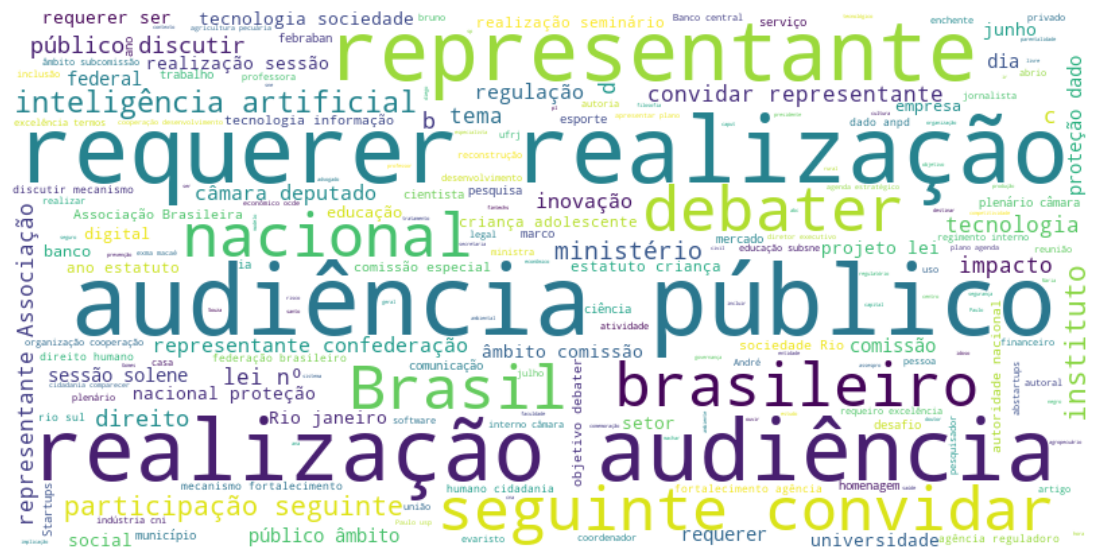

In [67]:
description = " ".join(cleaned_motions["ementa"])

word_counts_descriptions = Counter(description.split())
print("Top 20 palavras mais frequentes nas ementas:")
print(word_counts_descriptions.most_common(20))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(description)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Top 20 palavras mais frequentes nas pautas:
[('dep', 349), ('r', 343), ('n', 331), ('c', 249), ('s', 243), ('deputado', 231), ('p', 228), ('público', 225), ('d', 198), ('comissão', 190), ('representante', 177), ('t', 171), ('assinar', 168), ('eletronicamente', 165), ('verificar', 163), ('assinatura', 162), ('acer', 161), ('ã', 160), ('ç', 160), ('q', 160)]


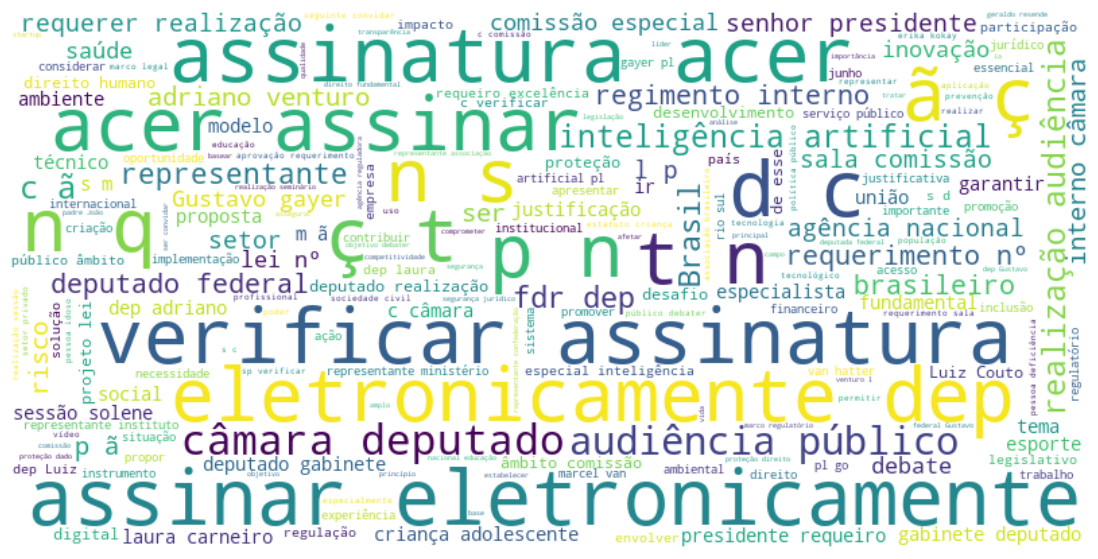

In [68]:
pdf_text = " ".join(cleaned_motions["pdf_text"])

pdf_text_word_counts = Counter(pdf_text.split())
print("Top 20 palavras mais frequentes nas pautas:")
print(pdf_text_word_counts.most_common(20))

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(pdf_text)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Temos as mesmas conclusões para a nuvem de palavras das pautas.

In [69]:
cleaned_motions["entities"] = cleaned_motions["ementa"].fillna("").apply(extract_ner)

In [70]:
ent_type_counter = Counter()
ent_text_by_type = defaultdict(list)

for ents in cleaned_events["entities"]:
    for text, label in ents:
        ent_type_counter[label] += 1
        ent_text_by_type[label].append(text)

In [71]:
print("Tipos de entidade mais frequentes nas ementas:")
for ent_type, count in ent_type_counter.most_common():
    print(f"{ent_type}: {count} ocorrências")

print("\nExemplos de entidades por tipo:")
for ent_type, texts in ent_text_by_type.items():
    exemplos = list(set(texts))[:5]  
    print(f"{ent_type}: {exemplos}")

Tipos de entidade mais frequentes nas ementas:
PER: 118 ocorrências
LOC: 68 ocorrências
ORG: 19 ocorrências
MISC: 9 ocorrências

Exemplos de entidades por tipo:
LOC: ['Secretaria', 'Rio', 'Educação', 'universidade brasília', 'universidade federal goiás ricardo paesr']
PER: ['Martins', 'Movimento Porto', 'Carlos', 'Maria', 'wagner lenhart']
ORG: ['Ministério Público Rio', 'Educação', 'Nacional', 'direteor', 'Nacional educação']
MISC: ['Am nº', 'nºs', 'sc alexsandro', 'comissão debater semana', 'Secretaria nacional Consumidor senacon']


In [72]:
cleaned_motions["entities_pdf_text"] = cleaned_motions["pdf_text"].fillna("").apply(extract_ner)

In [73]:
comissoes_dict = cleaned_events.set_index('id')['comission']

# Adiciona a nova coluna com base no id
cleaned_motions['comission'] = cleaned_motions['event_id'].map(comissoes_dict)

In [74]:
ent_type_counter = Counter()
ent_text_by_type = defaultdict(list)

for ents in cleaned_motions["entities_pdf_text"]:
    for text, label in ents:
        ent_type_counter[label] += 1
        ent_text_by_type[label].append(text)

print("Tipos de entidade mais frequentes nos pdfs:")
for ent_type, count in ent_type_counter.most_common():
    print(f"{ent_type}: {count} ocorrências")

print("\nExemplos de entidades por tipo:")
for ent_type, texts in ent_text_by_type.items():
    exemplos = list(set(texts))[:5]  
    print(f"{ent_type}: {exemplos}")

Tipos de entidade mais frequentes nos pdfs:
PER: 430 ocorrências
LOC: 250 ocorrências
MISC: 156 ocorrências
ORG: 66 ocorrências

Exemplos de entidades por tipo:
PER: ['heitor schuch alterar', 'Manuel', 'austráler', 'Wimmer', 'marcel van']
LOC: ['Peterson', 'Educação', 'Santa catarino', 'Banco Central', 'Faro']
MISC: ['c', 'd c bruno natal', 'otoni pt go', 'i c i t t r n', 'Gass pt']
ORG: ['união spu d c', 'união lfu liga futebol brasileiro', 'psb sp', 'petrobrás', 'psb ba requerer']


Mantemos a predominância de pessoas seguido de localizações.

In [75]:
def tokenize_motions(batch):
  # Garantia que os dados de texto serão strings
  texts = [str(text) for text in batch["ementa"]]

  # Caso acima de 512, trunca-se os dados
  # Para o caso de saúde não teremos esse comportamento
  encodings = tokenizer(texts, padding=True, truncation=True)

  # Preserva a coluna label de saída no map
  encodings["comission"] = batch["comission"]

  return encodings

In [76]:
motions_embedding = cleaned_motions[["ementa", "comission"]].dropna()
motions_embedding = motions_embedding[motions_embedding["ementa"] != ""].reset_index(drop=True)

In [77]:
motions_embedding_dataset = Dataset.from_pandas(motions_embedding)

In [78]:
motions_text_encoded = motions_embedding_dataset.map(
    tokenize_motions,
    batched=True, # Garante o processamento em batch
    batch_size=None # Define um valor dinâmico ao batch
)

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

Map: 100%|██████████| 59/59 [00:00<00:00, 1614.23 examples/s]


In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [80]:
motions_text_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "comission"]
) # Transforma os tokens em Tensors utilizando PyTorch

# Mapeia os Tensors com Tokens para o modelo, resgatando os valores da camada oculta
motions_hidden_features = motions_text_encoded.map(
    extract_hidden_states,
    batched=True
)

Map: 100%|██████████| 59/59 [00:19<00:00,  3.01 examples/s]


In [81]:
motions_hidden_features.column_names

['ementa',
 'comission',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden_state']

In [82]:
motions_hidden_features

Dataset({
    features: ['ementa', 'comission', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
    num_rows: 59
})

In [83]:
y_motions = motions_hidden_features["comission"]
X_motions = motions_hidden_features.remove_columns(["ementa", "comission"])

In [84]:
X_motions_scaled = MinMaxScaler().fit_transform(X_motions["hidden_state"])

mapper = UMAP(n_components=2, metric="cosine").fit(X_motions_scaled)

df_embedding = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_motions
df_embedding.head()

c:\Users\renne\anaconda3\envs\tcc-pos\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,10.234741,-3.537683,Plenário
1,10.488845,-4.271243,Plenário
2,8.119380,-3.569988,Comissão de Defesa do Consumidor
3,7.786089,-3.599249,Comissão de Meio Ambiente e Desenvolvimento Su...
4,10.182480,-2.974671,"Comissão de Agricultura, Pecuária, Abastecimen..."


In [85]:
df_embedding

,X,Y,label
0,10.234741,-3.537683,Plenário
1,10.488845,-4.271243,Plenário
2,8.119380,-3.569988,Comissão de Defesa do Consumidor
3,7.786089,-3.599249,Comissão de Meio Ambiente e Desenvolvimento Su...
4,10.182480,-2.974671,"Comissão de Agricultura, Pecuária, Abastecimen..."
5,9.108928,-3.017376,Comissão de Saúde
6,8.404939,-3.067551,Comissão de Saúde
7,7.686421,-2.646101,Subcomissão Permanente para tratar do Sistema ...
8,7.860366,-2.818283,Subcomissão Permanente para tratar do Sistema ...
9,7.603011,-2.752583,Subcomissão Permanente para tratar do Sistema ...


C:\Users\renne\AppData\Local\Temp\ipykernel_32104\786389788.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


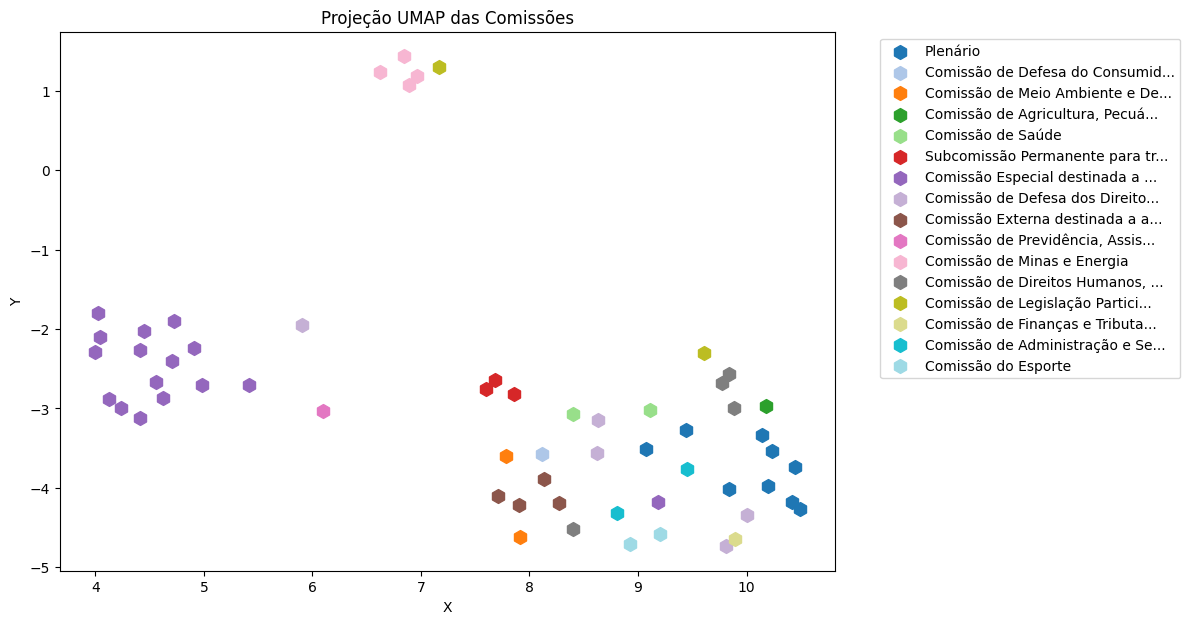

In [86]:
labels_trunc = df_embedding["label"].apply(lambda x: x[:30] + "..." if len(x) > 30 else x)

plt.figure(figsize=(10,7))

unique_labels = labels_trunc.unique()
colors = plt.cm.get_cmap('tab20', len(unique_labels))

for i, label in enumerate(unique_labels):
    idx = labels_trunc == label
    plt.scatter(
        df_embedding.loc[idx, "X"], 
        df_embedding.loc[idx, "Y"], 
        label=label, 
        marker='h',  # hexágono
        s=100,       # tamanho do marcador
        color=colors(i)
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Projeção UMAP das Comissões")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

As ementas nos trazem divisões bem claras entre os documentos! Sendo uma ótima fonte de dados contextuais referente as comissões. Temos poucos casos que apresentem interseccionalidades mais exageradas e estão difundidas entre as outras classificações.

In [97]:
def tokenize_pdf(batch):
  # Garantia que os dados de texto serão strings
  texts = [str(text) for text in batch["pdf_text"]]

  # Caso acima de 512, trunca-se os dados
  # Para o caso de saúde não teremos esse comportamento
  encodings = tokenizer(texts, padding=True, truncation=True, max_length=512)

  # Preserva a coluna label de saída no map
  encodings["comission"] = batch["comission"]

  return encodings

In [92]:
motions_embedding = cleaned_motions[["pdf_text", "comission"]].dropna()
motions_embedding = motions_embedding[motions_embedding["pdf_text"] != ""].reset_index(drop=True)

In [93]:
motions_embedding_dataset = Dataset.from_pandas(motions_embedding)

In [98]:
motions_text_encoded = motions_embedding_dataset.map(
    tokenize_pdf,
    batched=True, # Garante o processamento em batch
    batch_size=None # Define um valor dinâmico ao batch
)

Map: 100%|██████████| 59/59 [00:00<00:00, 1053.47 examples/s]


In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [99]:
motions_text_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "comission"]
) # Transforma os tokens em Tensors utilizando PyTorch

# Mapeia os Tensors com Tokens para o modelo, resgatando os valores da camada oculta
motions_hidden_features = motions_text_encoded.map(
    extract_hidden_states,
    batched=True
)


Map: 100%|██████████| 59/59 [00:43<00:00,  1.37 examples/s]


In [96]:
motions_hidden_features.column_names

['ementa',
 'comission',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden_state']

In [100]:
motions_hidden_features

Dataset({
    features: ['pdf_text', 'comission', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
    num_rows: 59
})

In [101]:
y_motions = motions_hidden_features["comission"]
X_motions = motions_hidden_features.remove_columns(["pdf_text", "comission"])

In [102]:
X_motions_scaled = MinMaxScaler().fit_transform(X_motions["hidden_state"])

mapper = UMAP(n_components=2, metric="cosine").fit(X_motions_scaled)

df_embedding = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_motions
df_embedding.head()

c:\Users\renne\anaconda3\envs\tcc-pos\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,9.961294,-0.509918,Plenário
1,8.961864,-0.514966,Plenário
2,13.187888,-2.288975,Comissão de Defesa do Consumidor
3,12.786043,-1.666218,Comissão de Meio Ambiente e Desenvolvimento Su...
4,12.459260,-0.404046,"Comissão de Agricultura, Pecuária, Abastecimen..."


In [103]:
df_embedding

,X,Y,label
0,9.961294,-0.509918,Plenário
1,8.961864,-0.514966,Plenário
2,13.187888,-2.288975,Comissão de Defesa do Consumidor
3,12.786043,-1.666218,Comissão de Meio Ambiente e Desenvolvimento Su...
4,12.459260,-0.404046,"Comissão de Agricultura, Pecuária, Abastecimen..."
5,11.957885,1.018367,Comissão de Saúde
6,11.868828,0.825335,Comissão de Saúde
7,11.235709,-0.370087,Subcomissão Permanente para tratar do Sistema ...
8,11.511521,-0.539534,Subcomissão Permanente para tratar do Sistema ...
9,11.352095,-0.740889,Subcomissão Permanente para tratar do Sistema ...


C:\Users\renne\AppData\Local\Temp\ipykernel_32104\1359967360.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


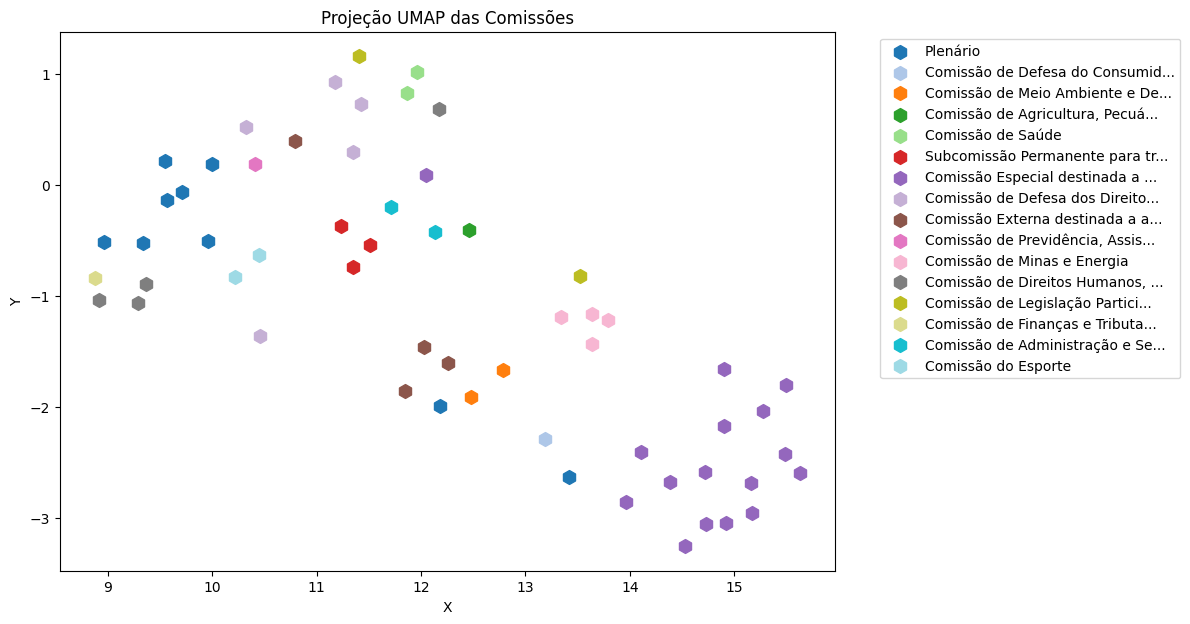

In [104]:
labels_trunc = df_embedding["label"].apply(lambda x: x[:30] + "..." if len(x) > 30 else x)

plt.figure(figsize=(10,7))

unique_labels = labels_trunc.unique()
colors = plt.cm.get_cmap('tab20', len(unique_labels))

for i, label in enumerate(unique_labels):
    idx = labels_trunc == label
    plt.scatter(
        df_embedding.loc[idx, "X"], 
        df_embedding.loc[idx, "Y"], 
        label=label, 
        marker='h',  # hexágono
        s=100,       # tamanho do marcador
        color=colors(i)
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Projeção UMAP das Comissões")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


Com os requerimentos conseguimos ver muito melhor a divisão dos temas! Com isso conseguimos definir como nosso principal dado a ser utilizado para nossa tarefa de identificação.

Mesmo com a presença de Jargões técnicos temos clusters muito bem definidos relativos as comissões, após a retirada de tais palavras pode ser que essa representação visual se torne ainda melhor.

Com isso vamos realziar uma abordagem de similaridade dupla, caso a ementa ou texto do requerimento estejam alinhados com o tema desejado, serão utilizados para a recuperação.

Os processamentos aqui realizados que constroem os embeddings serão repassados para scripts Python de forma modular. As etapas de limpeza e criação de colunas, estarão dispostas nos arquivos dentro da pasta `src/data_preprocess`, possuindo: `src/data_preprocess/cleaning.py`, em seguida de `src/data_preprocess/feature_engineering.py`.

## Criação de Banco Vetorial


Os embeddings aqui explorados e divididos por comissões, devem ser salvos em bancos vetoriais para possibiltiar uma pesquisa de documentos. Será utilizado o ChromaDB, criando as coleções para ementas e textos de requerimentos de forma separada.

Essa criação pode ser vista no arquivo: `src/data_preprocess/embedding_store.py`.